In [1]:
# -*- coding: utf-8 -*-
""" GAN Example

Use a generative adversarial network (GAN) to generate digit images from a
noise distribution.

References:
    - Generative adversarial nets. I Goodfellow, J Pouget-Abadie, M Mirza,
    B Xu, D Warde-Farley, S Ozair, Y. Bengio. Advances in neural information
    processing systems, 2672-2680.

Links:
    - [GAN Paper](https://arxiv.org/pdf/1406.2661.pdf).

"""

from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tflearn

# Data loading and preprocessing
import tflearn.datasets.mnist as mnist
X, Y, testX, testY = mnist.load_data()

Succesfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist/train-images-idx3-ubyte.gz
Succesfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist/train-labels-idx1-ubyte.gz
Succesfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Succesfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [23]:
tf.reset_default_graph()

In [24]:
image_dim = 784 # 28*28 pixels
z_dim = 200 # Noise data points
total_samples = len(X)


# Generator
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        x = tflearn.fully_connected(x, 256, activation='relu')
        x = tflearn.fully_connected(x, image_dim, activation='sigmoid')
        return x


# Discriminator
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        x = tflearn.fully_connected(x, 256, activation='relu')
        x = tflearn.fully_connected(x, 1, activation='sigmoid')
        return x

# Build Networks
gen_input = tflearn.input_data(shape=[None, z_dim], name='input_noise')
disc_input = tflearn.input_data(shape=[None, 784], name='disc_input')

gen_sample = generator(gen_input)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample, reuse=True)

# Define Loss
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))
gen_loss = -tf.reduce_mean(tf.log(disc_fake))

# Build Training Ops for both Generator and Discriminator.
# Each network optimization should only update its own variable, thus we need
# to retrieve each network variables (with get_layer_variables_by_scope) and set
# 'placeholder=None' because we do not need to feed any target.
gen_vars = tflearn.get_layer_variables_by_scope('Generator')
gen_model = tflearn.regression(gen_sample, placeholder=None, optimizer='adam', learning_rate=0.001,
                               loss=gen_loss, trainable_vars=gen_vars,
                               batch_size=64, name='target_gen', op_name='GEN')
disc_vars = tflearn.get_layer_variables_by_scope('Discriminator')
disc_model = tflearn.regression(disc_real, placeholder=None, optimizer='adam', learning_rate=0.001,
                                loss=disc_loss, trainable_vars=disc_vars,
                                batch_size=64, name='target_disc', op_name='DISC')
# Define GAN model, that output the generated images.
gan = tflearn.DNN(gen_model, tensorboard_dir='/home/hadoop/Documents/Neutrino/tensorboard_logs')

# Training
# Generate noise to feed to the generator
z = np.random.uniform(-1., 1., size=[total_samples, z_dim])
# Start training, feed both noise and real images.
gan.fit(X_inputs={gen_input: z, disc_input: X},
        Y_targets=None,
        n_epoch=10)

Training Step: 8599  | total loss: 4.13136 | time: 4.280s
| GEN | epoch: 010 | loss: 3.40676 -- iter: 54976/55000
| DISC | epoch: 010 | loss: 0.72460 -- iter: 54976/55000
Training Step: 8600  | total loss: 4.12421 | time: 4.285s
| GEN | epoch: 010 | loss: 3.39497 -- iter: 55000/55000
| DISC | epoch: 010 | loss: 0.72923 -- iter: 55000/55000
--


/home/hadoop/.local/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


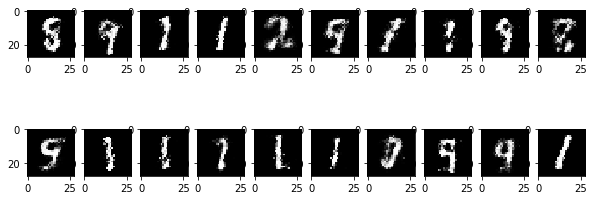

In [25]:

# Generate images from noise, using the generator network.
f, a = plt.subplots(2, 10, figsize=(10, 4))
for i in range(10):
    for j in range(2):
        # Noise input.
        z = np.random.uniform(-1., 1., size=[1, z_dim])
        # Generate image from noise. Extend to 3 channels for matplot figure.
        temp = [[ii, ii, ii] for ii in list(gan.predict([z])[0])]
        a[j][i].imshow(np.reshape(temp, (28, 28, 3)))
f.show()
plt.draw()